In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.12.0+cu113.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.12.0+cu113.html
     |████████████████████████████████| 7.9 MB 5.3 MB/s 
     |████████████████████████████████| 3.5 MB 73.1 MB/s 
     |████████████████████████████████| 2.4 MB 80.4 MB/s 
     |████████████████████████████████| 709 kB 73.9 MB/s 
     |████████████████████████████████| 467 kB 5.0 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.1.0.post1-py3-none-any.whl size=689859 sha256=a095076d031ae46e73f4b36d4e988cdbda799e61f70eb2391e10e0f5dcfc898d
  Stored in directory: /root/.cache/pip/wheels/d1/cb/43/f7f2e472de4d7cff31bceddadc36d634e1e545fbc17961c282
Successfully built torch-geometric


In [ ]:
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm
from random import randint
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
device = torch.device('cuda:0')
device

device(type='cuda', index=0)

In [ ]:
train_pre = pd.read_csv('/content/drive/Shareddrives/DSL_Modeling_E/Real_Estate/data/...')
test_pre = pd.read_csv('/content/drive/Shareddrives/DSL_Modeling_E/Real_Estate/data/...')

In [ ]:
train_pre[['gu']].value_counts()

gu          
gangseo         4097
guro            3983
yeongdeungpo    3970
seocho          3950
nowon           3902
songpa          3896
yangcheon       3886
guemcheon       3881
eunpyeong       3833
dobong          3784
gangdong        3783
dongjak         3748
mapo            3742
jungnang        3725
seongdong       3705
seongbuk        3703
gwangjin        3689
yongsan         3688
dongdaemun      3678
gangnam         3664
seodaemun       3661
gwanak          3651
jung            3625
gangbuk         3433
jongno          3152
dtype: int64

In [ ]:
train_pre = train_pre[train_pre['gu'].isin(['gangnam','seocho'])]
test_pre = test_pre[test_pre['gu'].isin(['gangnam','seocho'])]

In [ ]:
def Preprocess (train,test):
  # 필요없는 column drop
  train.drop(['Unnamed: 0','id','tagList','tag'],axis=1,inplace =True)
  test.drop(['Unnamed: 0','id','tagList','tag'],axis=1,inplace=True)
  # Normalization Fit (아직 transform은 안함)

  # scaler = StandardScaler()
  # scaler = scaler.fit(train.drop(['gu'],axis=1).iloc[:,:6])
  # # X, y 분리
  ten = torch.tensor(train.drop(['gu'],axis=1).iloc[:,:6].to_numpy())
  mean = ten.mean(dim=0)
  std = ten.mean(dim=0)
  mean ,std = mean.to(device), std.to(device)


  return train, test, mean, std


def adjacent_matrix(data):
  n = len(data)
  A = torch.tensor([0,0]).reshape(2,1)

  dist = (data[:,:2]*100)

  
  for i in range(0,n):
    for j in range(0,i):
      if i != j:
        a = (dist[i] - dist[j]).abs().sum()
        if a <= 0.2:
          A = torch.cat((A,torch.tensor([i,j]).reshape(2,1),torch.tensor([j,i]).reshape(2,1)),dim=1 )
  A = A[:,1:]
  
  return A.to(device)

In [ ]:
# column 필요없는거 제거된 게 필요함!

class Graph_data(Dataset):
  def __init__(self, data, n):
    self.GU = data['gu'].unique()
    self.gu = []
    self.x = []
    self.y = []
    self.first = True

    for i in tqdm(range(n)):
      for gu in self.GU:
        #데이터의 구 
        self.gu.append(gu)
        df = data[data['gu'] ==gu].sample(randint(1000,1300))
        a = torch.tensor(df.drop(['gu','deposit','monthlyPay'],axis =1).to_numpy(),dtype = torch.float).unsqueeze(0)
        b = torch.tensor(df[['deposit','monthlyPay']].to_numpy(),dtype = torch.float).unsqueeze(0)
        self.x.append(a)
        self.y.append(b)

        
  def __len__(self):
    return len(self.x)

  def __getitem__(self, idx):
    return self.x[idx], self.y[idx]
    #  self.gu[idx]

In [ ]:
train, test,mean,std = Preprocess(train_pre,test_pre)

In [ ]:
test.drop('Unnamed: 0.1',axis=1,inplace=True)

In [ ]:
dataset = Graph_data(train,500)

100%|██████████| 500/500 [00:02<00:00, 171.75it/s]


In [ ]:
testset = Graph_data(test,100)

100%|██████████| 100/100 [00:00<00:00, 216.67it/s]


In [ ]:
class Model (nn.Module):
    def __init__(self,init_features,final_features):
        super(Model, self).__init__()
        # One-hot feature들 중 embedding 거칠 layer
        self.emb_goods = nn.Linear(11,5)
        self.emb_direc = nn.Linear(8,2)
        # GCN Conv Layer
        self.conv1 = GCNConv(init_features, 24)  # 처음 GCN에 넣어 줄 feature 수 
        self.conv2 = GCNConv(24, final_features)  # 마지막으로 설정 할 feature 수
        # GCN 거친 Embedding이 들어갈 fc Layer
        self.fc1 = nn.Linear(final_features,15)
        self.fc2 = nn.Linear(15,10)
        self.fc3 = nn.Linear(10,5)
        self.fc4 = nn.Linear(5,3)
        #self.fc5 = nn.Linear(15,10)
        #self.fc6 = nn.Linear(10,5)
        #self.fc7 = nn.Linear(5,3)
        # Deposit Output Layer
        self.depos_output = nn.Linear(3,1)
        # Monthly Output Layer
        self.month_output = nn.Linear(4,1)
        # Activation Func
        self.ReLU = nn.ReLU()


    def forward(self,x,edge_index):
        
        # Split Input Features
        x_goods = x[:,-19:-8] # 확인해보기
        x_direc = x[:,-8:]
        x_raw = x[:,:-19]

        # Feature Embedding (One-hot features)
        emb1 = self.emb_goods(x_goods)
        emb2 = self.emb_direc(x_direc)

        # GCN Forward
        y = self.conv1(torch.cat((x_raw,emb1,emb2),1), edge_index)
        y = F.relu(y)
        y = F.dropout(y,0.2)
        y = self.conv2(y, edge_index)

        # fc Forward
        o = self.fc1(y)
        o = self.fc2(o)
        o = self.fc3(o)
        o = self.fc4(o)
        #o = self.fc5(o)
        #o = self.fc6(o)
        #o = self.fc7(o)

        # Deposit Out
        dep = self.depos_output(o)

        # Month Out
        mon = self.month_output(torch.cat((o,dep),1))

        return torch.cat((dep,mon),1)

In [ ]:
k =6 # Non ONe-hot features
model = Model(11+k,20).to(device)
# data = dataset[0].to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)#, weight_decay=5e-4)
criterion = nn.MSELoss().to(device) 

In [ ]:
seq_train_loss = []

In [ ]:
# Train Def

def train_(epoch):
    print(f'\n[ Train epoch: {epoch+1} ]')

    model.train() 

    running_loss = 0.0
    batch_losses = []

    for batch_idx, (inputs, targets) in enumerate(train_dataloader):
        inputs, targets = inputs.to(device), targets.to(device) 

        # Adjacent Matrix 구하기
        adjacent = adjacent_matrix(inputs)

        # Scaler 적용

        # a = inputs.squeeze()[:,:6].clone().detach()
        # a = (a - mean)/std
        inputs[0,0,:,:6] = (inputs.squeeze()[:,:6] -mean)/std.unsqueeze(0).unsqueeze(0)

        # DL 학습 기본 코드
        optimizer.zero_grad() 
        outputs = model(inputs.squeeze(0).squeeze(0),adjacent) 
        loss = criterion(outputs, targets) 
        loss.backward() 
        optimizer.step() 

        running_loss += loss.item()
        batch_losses.append(loss.item())
        
        if batch_idx % 200 == 199:
            print(f'\nCurrent batch: {str(batch_idx+1)}')
            print(f'Average train loss of recent 1 batches: {running_loss / 200}') 
            running_loss = 0.0

    avg_loss = sum(batch_losses) / len(batch_losses)
    seq_train_loss.append(avg_loss)
    print('Total train loss:', avg_loss)

In [ ]:
seq_test_loss=[]

In [ ]:
# Test Def

def test_(epoch):
    print(f'\n[ Test epoch: {epoch+1} ]')

    model.eval() 

    loss = 0
    batch_losses = []

    with torch.no_grad(): 
        for batch_idx, (inputs, targets) in enumerate(test_dataloader):
            inputs, targets = inputs.to(device), targets.to(device)
            # Adjacent 
            adjacent = adjacent_matrix(inputs)

            # Scaler 적용
            inputs[0,0,:,:6] = (inputs.squeeze()[:,:6] -mean)/std.unsqueeze(0).unsqueeze(0)

            
            outputs = model(inputs.squeeze(0).squeeze(0),adjacent)
            loss = criterion(outputs, targets)
            batch_losses.append(loss.item())

    avg_loss = sum(batch_losses) / len(batch_losses)
    seq_test_loss.append(avg_loss)
    print('Test average loss:', avg_loss)

In [ ]:
train_dataloader =DataLoader(dataset,batch_size=1, shuffle = False)
test_dataloader = DataLoader(testset,batch_size=1, shuffle = False)

In [ ]:
testset[0][0][0].shape

torch.Size([1049, 30])

In [ ]:
train.columns

Index(['lat', 'lng', 'gu', 'floor', 'floor_total', 'contractArea', 'realArea',
       'deposit', 'monthlyPay', 'payType_단기임대', 'payType_매매', 'payType_월세',
       'payType_전세', 'goodsType_단독/다가구', 'goodsType_빌라', 'goodsType_사무실',
       'goodsType_상가', 'goodsType_상가주택', 'goodsType_아파트', 'goodsType_오피스텔',
       'goodsType_원룸', 'goodsType_재개발', 'goodsType_재건축/아파트분양권',
       'goodsType_지식산업센터', 'direction_남동향', 'direction_남서향', 'direction_남향',
       'direction_동향', 'direction_북동향', 'direction_북서향', 'direction_북향',
       'direction_서향'],
      dtype='object')

In [ ]:
test.columns

Index(['lat', 'lng', 'gu', 'floor', 'floor_total', 'contractArea', 'realArea',
       'deposit', 'monthlyPay', 'payType_단기임대', 'payType_매매', 'payType_월세',
       'payType_전세', 'goodsType_단독/다가구', 'goodsType_빌라', 'goodsType_사무실',
       'goodsType_상가', 'goodsType_상가주택', 'goodsType_아파트', 'goodsType_오피스텔',
       'goodsType_원룸', 'goodsType_재개발', 'goodsType_재건축/아파트분양권',
       'goodsType_지식산업센터', 'direction_남동향', 'direction_남서향', 'direction_남향',
       'direction_동향', 'direction_북동향', 'direction_북서향', 'direction_북향',
       'direction_서향'],
      dtype='object')

In [ ]:
epochs = 50
for i in range(0,epochs):
  train_(i)
  test_(i) 


[ Train epoch: 1 ]


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1, 1, 1277, 2])) that is different to the input size (torch.Size([1277, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1, 1, 1006, 2])) that is different to the input size (torch.Size([1006, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1, 1, 1294, 2])) that is different to the input size (torch.Size([1294, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the s


Current batch: 200
Average train loss of recent 1 batches: 2631114322.88


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1, 1, 1070, 2])) that is different to the input size (torch.Size([1070, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1, 1, 1148, 2])) that is different to the input size (torch.Size([1148, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1, 1, 1181, 2])) that is different to the input size (torch.Size([1181, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the s


Current batch: 400
Average train loss of recent 1 batches: 1403270079.68


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1, 1, 1128, 2])) that is different to the input size (torch.Size([1128, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1, 1, 1020, 2])) that is different to the input size (torch.Size([1020, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1, 1, 1170, 2])) that is different to the input size (torch.Size([1170, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the s


Current batch: 600
Average train loss of recent 1 batches: 1185159726.72


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1, 1, 1280, 2])) that is different to the input size (torch.Size([1280, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1, 1, 1164, 2])) that is different to the input size (torch.Size([1164, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1, 1, 1275, 2])) that is different to the input size (torch.Size([1275, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the s


Current batch: 800
Average train loss of recent 1 batches: 1120914686.4


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1, 1, 1131, 2])) that is different to the input size (torch.Size([1131, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1, 1, 1045, 2])) that is different to the input size (torch.Size([1045, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1, 1, 1084, 2])) that is different to the input size (torch.Size([1084, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the s


Current batch: 1000
Average train loss of recent 1 batches: 1083651272.8


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1, 1, 1297, 2])) that is different to the input size (torch.Size([1297, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1, 1, 1086, 2])) that is different to the input size (torch.Size([1086, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1, 1, 1085, 2])) that is different to the input size (torch.Size([1085, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the s


Current batch: 1200
Average train loss of recent 1 batches: 1065212262.56


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1, 1, 1268, 2])) that is different to the input size (torch.Size([1268, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Current batch: 1400
Average train loss of recent 1 batches: 1107138923.2
Total train loss: 1353900090.24

[ Test epoch: 1 ]


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1, 1, 1107, 2])) that is different to the input size (torch.Size([1107, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test average loss: 1363284127.2533333

[ Train epoch: 2 ]

Current batch: 200
Average train loss of recent 1 batches: 1000312115.36

Current batch: 400
Average train loss of recent 1 batches: 1066594549.28

Current batch: 600
Average train loss of recent 1 batches: 1061428905.92

Current batch: 800
Average train loss of recent 1 batches: 1056143276.64

Current batch: 1000
Average train loss of recent 1 batches: 1034874842.08

Current batch: 1200
Average train loss of recent 1 batches: 1029800484.48

Current batch: 1400
Average train loss of recent 1 batches: 1075653543.36
Total train loss: 1049499650.9653333

[ Test epoch: 2 ]
Test average loss: 1339153341.0133333

[ Train epoch: 3 ]

Current batch: 200
Average train loss of recent 1 batches: 975339777.44

Current batch: 400
Average train loss of recent 1 batches: 1041741267.36

Current batch: 600
Average train loss of recent 1 batches: 1039591564.16

Current batch: 800
Average train loss of recent 1 batches: 1036484097.28

Current bat

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
train_loss_all_area = np.sqrt(np.array(seq_train_loss))
test_loss_all_area = np.sqrt(np.array(seq_test_loss))

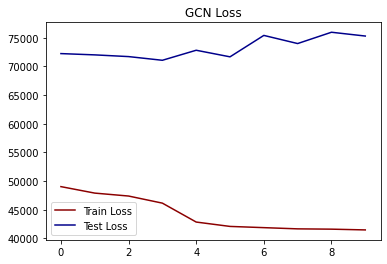

In [ ]:
# With all area
plt.title('GCN Loss')
plt.plot(train_loss_all_area,color='darkred',label='Train Loss')
plt.plot(test_loss_all_area,color='darkblue',label='Test Loss')
plt.legend()

In [ ]:
train_loss_gs = np.sqrt(np.array(seq_train_loss))
test_loss_gs = np.sqrt(np.array(seq_test_loss))

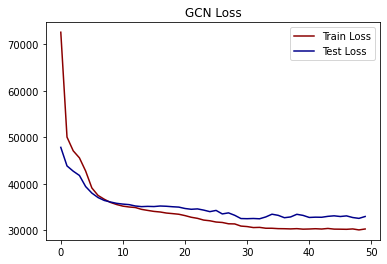

In [ ]:
# With Gangnam and Seocho
plt.title('GCN Loss')
plt.plot(train_loss_gs,color='darkred',label='Train Loss')
plt.plot(test_loss_gs,color='darkblue',label='Test Loss')
plt.legend()

In [ ]:
train_loss_ysd = np.sqrt(np.array(seq_train_loss))
test_loss_ysd = np.sqrt(np.array(seq_test_loss))

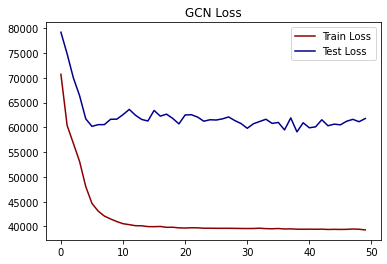

In [ ]:
# With Gangnam and Seocho
plt.title('GCN Loss')
plt.plot(train_loss_ysd,color='darkred',label='Train Loss')
plt.plot(test_loss_ysd,color='darkblue',label='Test Loss')
plt.legend()

In [ ]:
M = torch.load('/content/drive/Shareddrives/DSL_Modeling_E/...')
M.eval()

Model(
  (emb_goods): Linear(in_features=11, out_features=5, bias=True)
  (emb_direc): Linear(in_features=8, out_features=2, bias=True)
  (conv1): GCNConv(17, 24)
  (conv2): GCNConv(24, 20)
  (fc1): Linear(in_features=20, out_features=15, bias=True)
  (fc2): Linear(in_features=15, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=5, bias=True)
  (fc4): Linear(in_features=5, out_features=3, bias=True)
  (depos_output): Linear(in_features=3, out_features=1, bias=True)
  (month_output): Linear(in_features=4, out_features=1, bias=True)
  (ReLU): ReLU()
)